### After some research later, I found that a CNN-based fraud detection network is proposed to capture the intrinsic patterns of fraud behaviors learned from labeled data.

### Thus, here I will perform CNN on the dataset for credit card fraud detection.

In [1]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import BatchNormalization,Dropout,Dense,Flatten,Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/creditcard.csv.zip')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# 1. Exploring and Assessing the Data
### *   V1, V2, … V28 are the principal components obtained with PCA
### *   features which have not been transformed with PCA are 'Time' and 'Amount'
### *   'Time' contains the seconds elapsed between **each transaction** and the **first transaction** in the dataset
### *   'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning
### *   'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df.shape

(284807, 31)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [6]:
# check for any null values in dataset
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

# 2. Uneven class distribution

### This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

In [7]:
# check amount of fraud(1) and non-fraud(0) transactions
df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [8]:
non_fraud = df[df.Class==0] # dataset with class 0 only
fraud = df[df.Class==1] # dataset with class 1 only

In [9]:
non_fraud.shape, fraud.shape

((284315, 31), (492, 31))

### To deal the uneven class distributiion, I extracted the equal amount of fraud transactions (492) from non-frauds randomly. Now `non_fraud.shape = fraud.shape`, so we can say the data is now balanced!

In [10]:
non_fraud = non_fraud.sample(492)

In [11]:
data = fraud.append(non_fraud, ignore_index=True) # 492(fraud) + 738(no fraud) = 1230
data

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,-2.772272,3.202033,-2.899907,-0.595222,-4.289254,0.389724,-1.140747,-2.830056,-0.016822,0.416956,0.126911,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1
1,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,-0.838587,-0.414575,-0.503141,0.676502,-1.692029,2.000635,0.666780,0.599717,1.725321,0.283345,2.102339,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1
2,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,-1.525412,2.032912,-6.560124,0.022937,-1.470102,-0.698826,-2.282194,-4.781831,-2.615665,-1.334441,-0.430022,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1
3,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,-4.801637,4.895844,-10.912819,0.184372,-6.771097,-0.007326,-7.358083,-12.598419,-5.131549,0.308334,-0.171608,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1
4,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,-2.447469,2.101344,-4.609628,1.464378,-6.079337,-0.339237,2.581851,6.739384,3.042493,-2.721853,0.009061,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
979,143959.0,2.046396,0.274132,-1.725500,0.549005,0.233682,-1.528319,0.338430,-0.441672,0.471975,-0.538456,-0.182146,0.447139,0.741870,-0.980385,0.825814,0.198546,0.437020,0.450875,-0.458095,-0.145029,0.202288,0.786607,-0.034560,-0.005432,0.275683,-0.107035,0.002836,-0.026231,8.64,0
980,49674.0,1.240979,0.523695,-0.261839,0.971426,-0.316965,-1.746610,0.322392,-0.280320,-0.005271,-0.560932,0.374313,-0.569984,-1.400896,-0.733167,1.035672,0.361743,1.080467,0.118757,-0.515923,-0.175031,-0.117520,-0.346626,0.001765,0.796670,0.457759,0.339913,-0.041498,0.039346,0.76,0
981,59174.0,-0.990303,-0.767309,2.720717,0.701788,-0.550559,1.530591,-0.277609,0.437614,-0.990124,0.537495,0.866140,0.187374,-0.723500,-0.414429,-0.255595,-2.584656,0.884029,1.051256,-0.052564,0.028323,-0.324361,-0.393585,0.242233,-0.353559,-0.049917,-0.246471,-0.035646,-0.126193,140.11,0
982,42628.0,0.346710,-2.657195,0.375268,-1.577909,-2.001368,0.268247,-0.536604,0.087068,0.705615,-0.608531,1.170644,1.834583,0.843227,-0.392036,-0.317104,-2.447741,0.561112,1.085078,0.149234,0.495675,-0.172665,-0.723140,-0.332291,0.070253,0.049905,-0.141142,0.002975,0.100102,487.54,0


In [12]:
data.shape

(984, 31)

In [13]:
# now the number of frauds and non-frauds should be equal
data.Class.value_counts()

1    492
0    492
Name: Class, dtype: int64

#3. Dividing our now balanced dataset into Training, and Testing sets

In [14]:
X = data.drop(['Class'], axis=1) # dataset without 'Class' column
y = data['Class']
y

0      1
1      1
2      1
3      1
4      1
      ..
979    0
980    0
981    0
982    0
983    0
Name: Class, Length: 984, dtype: int64

In [15]:
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.2, stratify=y)
X_train.shape,X_test.shape

((787, 30), (197, 30))

In [16]:
y_train

429    1
594    0
504    0
579    0
414    1
      ..
272    1
794    0
412    1
839    0
104    1
Name: Class, Length: 787, dtype: int64

In [17]:
X_train

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
429,148479.0,-1.541678,3.846800,-7.604114,3.121459,-1.254924,-2.084875,-2.385027,1.471140,-2.530507,-5.175660,1.927186,-6.011155,-1.195601,-6.745561,-0.058091,-4.325132,-5.558067,-1.580531,0.971906,0.114760,1.096405,1.064222,0.065370,0.257209,-0.693654,-0.335702,0.577052,0.398348,122.68
594,124641.0,-1.697459,1.125117,0.972545,-0.807778,0.804043,0.328162,1.500448,-0.698200,1.905846,2.029610,0.596014,0.439339,-0.933631,-1.437006,-2.411074,-1.049723,-0.495757,-0.608921,0.721456,0.700127,-0.701474,-0.560431,-0.253674,0.765144,0.047617,-0.051781,-0.023450,-0.318815,44.02
504,160990.0,1.600931,-0.760494,-3.221276,-0.022574,1.617255,0.726604,0.885328,0.022721,0.130184,-0.063268,0.700622,0.295312,-1.500679,1.455636,0.275520,-1.521718,0.286981,-0.826277,-0.425521,0.042084,0.504631,1.174546,-0.394119,-0.902456,0.647124,-0.133101,-0.061431,-0.066921,222.04
579,60802.0,1.256891,0.412449,0.320474,0.684504,-0.296985,-1.050841,0.141931,-0.249621,-0.089946,-0.306569,0.067391,0.664494,1.037807,-0.449165,1.005392,0.442078,-0.053553,-0.396892,-0.201924,-0.028231,-0.278517,-0.764597,0.118785,0.362026,0.244178,0.092009,-0.017815,0.032544,1.98
414,143456.0,-2.006582,3.676577,-5.463811,7.232058,-1.627859,-0.996755,-4.299833,2.268867,-3.651067,-4.400930,4.213213,-5.737815,-0.875693,-8.893726,-0.562434,-3.281784,-4.368986,-0.736734,1.609293,0.474414,0.713907,-0.063868,0.167947,-0.449864,0.023702,0.536905,0.485864,-0.042393,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,85285.0,-7.030308,3.421991,-9.525072,5.270891,-4.024630,-2.865682,-6.989195,3.791551,-4.622730,-8.409665,6.309044,-8.576761,0.246747,-11.534046,-0.364265,-5.452495,-11.887570,-3.563585,0.876019,0.545698,1.103398,-0.541855,0.036943,-0.355519,0.353634,1.042458,1.359516,-0.272188,0.00
794,124146.0,-2.170643,-0.395896,-0.938187,-0.833246,0.182467,-1.384598,1.220113,0.027988,0.595414,-1.967320,-1.250299,-0.681395,-1.716391,-1.041210,-0.994052,0.762491,0.719534,0.253245,-1.133377,-0.751150,-0.205930,-0.537423,-0.515336,-0.121818,-0.458219,-0.382814,0.082994,-0.150687,242.72
412,143434.0,-2.729482,3.312495,-4.242710,5.036985,-0.376561,-1.532462,-3.449159,1.856839,-3.623334,-5.653638,3.942316,-5.883724,-1.347814,-9.266120,-2.459556,-2.205644,-5.709087,-1.113937,-1.556530,0.164288,0.727415,-0.301432,-0.502433,-0.462309,0.510683,0.046665,0.514646,0.140999,1.00
839,120925.0,0.770332,0.961677,-1.805102,0.606707,0.883455,0.401683,-0.212321,-3.004900,-1.181618,-0.149371,0.026322,0.742683,0.571058,1.464099,0.926995,-0.904814,0.011619,0.723185,3.180973,0.964948,-1.072866,1.092898,-0.229132,-1.286775,0.619731,0.718874,0.150836,0.293593,38.25


### Scale data to deal with the high variance in the data, and converrtr data into numpy array.

In [18]:
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.fit_transform(X_test)
X_train

array([[ 1.22900548,  0.12915879,  0.6065327 , ...,  0.46968411,
         0.81624783,  0.06361708],
       [ 0.7406253 ,  0.09929788, -0.1578964 , ..., -0.10047883,
        -0.75275784, -0.23771181],
       [ 1.48532415,  0.73155423, -0.6875014 , ..., -0.13654075,
        -0.20166516,  0.44424305],
       ...,
       [ 1.12564622, -0.09852693,  0.45646435, ...,  0.41043125,
         0.25321988, -0.40251183],
       [ 0.66449388,  0.57233965, -0.20380126, ...,  0.06500157,
         0.58706417, -0.25981539],
       [-0.99169225,  0.63240661, -0.14262183, ...,  0.01360227,
         0.19627872, -0.40251183]])

In [19]:
y_train=y_train.to_numpy()
y_test=y_test.to_numpy()
y_train

array([1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1,

### Change shape of data to be processed by CNN model.

In [20]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

X_train.shape, X_test.shape

((787, 30, 1), (197, 30, 1))

# 4. Build CNN model

In [21]:
model=Sequential()

model.add(Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=X_train[0].shape))
model.add(BatchNormalization())
# model.add(MaxPooling1D(2))
model.add(Dropout(0.1))

model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(BatchNormalization())
# model.add(MaxPooling1D(2))
model.add(Dropout(0.2))

# convert input into single array
model.add(Flatten())
# a hidden fully-connected layer with 64 nodes
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# a hidden fully-connected layer with 1 node
model.add(Dense(1, activation='sigmoid'))

In [22]:
X_train[0].shape

(30, 1)

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 29, 32)            96        
_________________________________________________________________
batch_normalization (BatchNo (None, 29, 32)            128       
_________________________________________________________________
dropout (Dropout)            (None, 29, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 28, 64)            4160      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 64)            256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1792)              0

In [24]:
# compile model
model.compile(optimizer=Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics=['accuracy'])

### I observed that using the sigmoid function in the last layer yields a higher accuracy than using relu. When relu was used before, the validation accuracy was approximately 90%. But as seen here the validation accuracy reached 94.9%. The following can be seen at the bottom of the `history`:

```
training loss: 0.1474
training accuracy: 0.9492
validation loss: 0.0.1297
validation accuracy: 0.9492
```



In [25]:
# fit the model (training happens here)
history = model.fit(X_train, y_train, epochs=25, validation_data=(X_test, y_test), shuffle=True)

Epoch 1/25
25/25 [==============================] - 0s 17ms/step - loss: 0.7243 - accuracy: 0.7001 - val_loss: 0.5956 - val_accuracy: 0.8528
Epoch 2/25
25/25 [==============================] - 0s 8ms/step - loss: 0.4180 - accuracy: 0.8361 - val_loss: 0.5643 - val_accuracy: 0.9340
Epoch 3/25
25/25 [==============================] - 0s 9ms/step - loss: 0.2865 - accuracy: 0.8996 - val_loss: 0.5368 - val_accuracy: 0.9340
Epoch 4/25
25/25 [==============================] - 0s 9ms/step - loss: 0.2810 - accuracy: 0.8983 - val_loss: 0.5049 - val_accuracy: 0.9137
Epoch 5/25
25/25 [==============================] - 0s 9ms/step - loss: 0.2734 - accuracy: 0.8996 - val_loss: 0.4775 - val_accuracy: 0.9086
Epoch 6/25
25/25 [==============================] - 0s 10ms/step - loss: 0.2312 - accuracy: 0.9187 - val_loss: 0.4524 - val_accuracy: 0.8985
Epoch 7/25
25/25 [==============================] - 0s 9ms/step - loss: 0.2533 - accuracy: 0.9098 - val_loss: 0.4259 - val_accuracy: 0.9036
Epoch 8/25
25/25 [

#5. Plot Training and Validation Accuracy
### As seen, the accuracy gradually increases and loss decreases in each epoch, which is what we want.

In [26]:
def plotLearningCurve(history,epochs):
  epochRange = range(1, epochs+1)
  plt.plot(epochRange, history.history['accuracy'])
  plt.plot(epochRange, history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(['Train','Validation'],loc='upper left')
  plt.show()

  plt.plot(epochRange,history.history['loss'])
  plt.plot(epochRange,history.history['val_loss'])
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Train','Validation'],loc='upper left')
  plt.show()

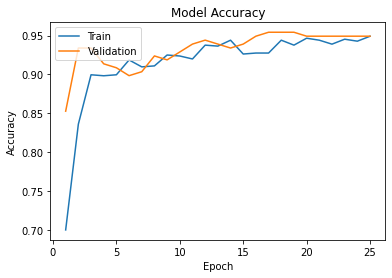

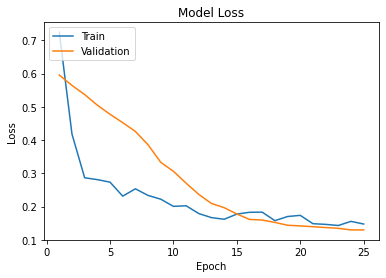

In [27]:
plotLearningCurve(history,25)